In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearson3

# Site info
# https://waterdata.usgs.gov/monitoring-location/13338950/#parameterCode=00060&period=P7D&showMedian=false

In [2]:
# Load data as pandas.Series
streamflow = xr.open_dataarray("NWM_23606454.nc").to_dataframe()["streamflow"]

In [3]:
# Result is pandas.Series of streamflow data with a DateTimeIndex in m^3/s
streamflow.head()

time
1979-02-01 01:00:00    0.02
1979-02-01 02:00:00    0.02
1979-02-01 03:00:00    0.02
1979-02-01 04:00:00    0.02
1979-02-01 05:00:00    0.02
Name: streamflow, dtype: float64

In [4]:
# Look at data limits
streamflow.index.min(), streamflow.index.max()

(Timestamp('1979-02-01 01:00:00'), Timestamp('2023-02-01 00:00:00'))

In [5]:
# Trim to whole water-years (Oct 1 - Sep 30)
# Note padding of 6 days so every water year
# will have the same number of 7-day averages
start = pd.Timestamp("1979-10-01T00:00") - pd.Timedelta("6d")
end = pd.Timestamp("2022-09-30T23:00")
streamflow_trimmed = streamflow[start:end]

In [6]:
# NWM data is hourly. The 7Q10 method assumes daily streamflow
# We'll need to resample to daily mean streamflow, first
streamflow_daily = streamflow_trimmed.resample("1D", closed="left", label="left").mean()

In [7]:
# Resample to 7-day rolling average streamflow
# Note that with NWM data, you shouldn't have to worry about
# handling missing data. If this were observed, we'd need to handle that.
streamflow_7day = streamflow_daily.rolling(window="7d", min_periods=7).mean().dropna()

In [8]:
# Note that after all this resampling
# we've lost the first six days of data
# That is the first time we can take a 7-day average
# is the end of the 7th day of the entire record.
streamflow_7day.head()

time
1979-10-01    0.03
1979-10-02    0.03
1979-10-03    0.03
1979-10-04    0.03
1979-10-05    0.03
Freq: D, Name: streamflow, dtype: float64

In [9]:
# Now we compute the yearly minimums
streamflow_yearly_min = streamflow_7day.resample("1YE").min()

# Update the index
streamflow_yearly_min.index.name = "water_year"
streamflow_yearly_min.index = streamflow_yearly_min.index.year

In [10]:
streamflow_yearly_min.head()

water_year
1979    0.020000
1980    0.020000
1981    0.021964
1982    0.020000
1983    0.010000
Name: streamflow, dtype: float64

In [11]:
# Empirical 7Q10
empirical_7Q10 = streamflow_yearly_min.quantile(0.1)
f"Empirical 7Q10 rounded to model precision is {empirical_7Q10:.2f} m^3/s"

'Empirical 7Q10 rounded to model precision is 0.01 m^3/s'

In [12]:
# Fitting to a distribution
pearson_params = pearson3.fit(streamflow_yearly_min)
fitted_7Q10 = pearson3.ppf(0.1, *pearson_params)
f"Fitted 7Q10 rounded to model precision is {fitted_7Q10:.2f} m^3/s"

'Fitted 7Q10 rounded to model precision is 0.01 m^3/s'

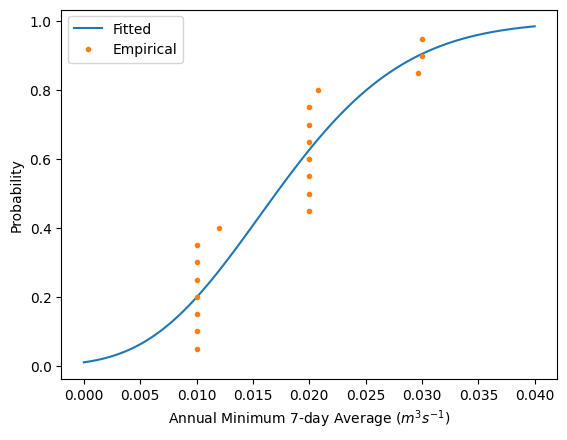

In [13]:
# Plot fit
x = np.linspace(streamflow_yearly_min.min(), streamflow_yearly_min.max(), 100)
y = pearson3.cdf(x, *pearson_params)
y_emp = np.linspace(0.05, 0.95, 19)
x_emp = streamflow_yearly_min.quantile(y_emp)
plt.plot(x, y, label="Fitted")
plt.plot(x_emp, y_emp, ".", label="Empirical")
plt.xlabel("Annual Minimum 7-day Average ($m^3 s^{-1}$)")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [14]:
# Notice in the plot above that the fitted distribution is a lot smoother
# This is because the model output has fixed precision (0.01 m^3/s)
# When dealing with low flow thresholds that are going to be applied to 
# modeled streamflow, the increased precision of the fitted distribution
# isn't really doing anything. So in this case it may be better to just go with 
# the empirical values.